In [1]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"erfanakbarnezhad","key":"ccf0dc5b13a275227774fe72d6e0cf97"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d sshikamaru/car-object-detection

Dataset URL: https://www.kaggle.com/datasets/sshikamaru/car-object-detection
License(s): other
100% 112M/112M [00:06<00:00, 23.1MB/s]
100% 112M/112M [00:06<00:00, 19.3MB/s]


In [3]:
!unzip "/content/car-object-detection.zip"

Archive:  /content/car-object-detection.zip
  inflating: data/sample_submission.csv  
  inflating: data/testing_images/vid_5_25100.jpg  
  inflating: data/testing_images/vid_5_25120.jpg  
  inflating: data/testing_images/vid_5_25140.jpg  
  inflating: data/testing_images/vid_5_25160.jpg  
  inflating: data/testing_images/vid_5_25180.jpg  
  inflating: data/testing_images/vid_5_25200.jpg  
  inflating: data/testing_images/vid_5_25220.jpg  
  inflating: data/testing_images/vid_5_25240.jpg  
  inflating: data/testing_images/vid_5_25260.jpg  
  inflating: data/testing_images/vid_5_26320.jpg  
  inflating: data/testing_images/vid_5_26400.jpg  
  inflating: data/testing_images/vid_5_26420.jpg  
  inflating: data/testing_images/vid_5_26560.jpg  
  inflating: data/testing_images/vid_5_26580.jpg  
  inflating: data/testing_images/vid_5_26600.jpg  
  inflating: data/testing_images/vid_5_26620.jpg  
  inflating: data/testing_images/vid_5_26640.jpg  
  inflating: data/testing_images/vid_5_26660.jp

In [4]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread("/content/data/training_images/vid_4_10060.jpg")

In [5]:
img_grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

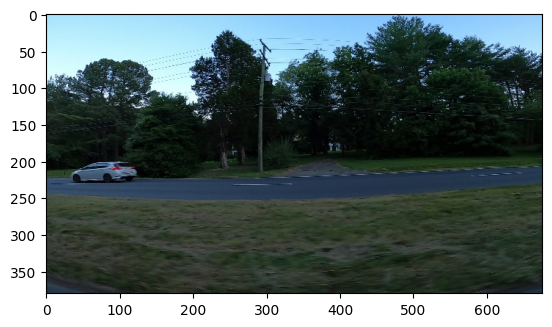

In [6]:
plt.subplot(1,1,1)
plt.imshow(img_rgb)
plt.show()

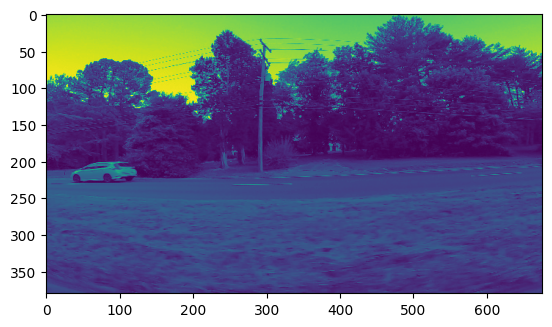

In [7]:
plt.subplot(1,1,1)
plt.imshow(img_grey)
plt.show()

In [8]:
import os
import pandas as pd
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
import yaml
import shutil

In [9]:
!pip install ultralytics -q
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.51 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.5/78.2 GB disk)


In [10]:
from ultralytics import YOLO
model = YOLO('yolov8x.pt')

100%|██████████| 131M/131M [00:00<00:00, 483MB/s]


In [11]:
train_data = '/content/data/training_images'
train_csv = '/content/data/train_solution_bounding_boxes (1).csv'
test_data = '/content/data/testing_images'

In [12]:
!mkdir -p "DATA"


In [13]:
!mkdir -p "DATA/images"

In [14]:

!mkdir -p "DATA/images/train"
!mkdir -p "DATA/images/val"

In [15]:
!mkdir -p "DATA/labels"

!mkdir -p "DATA/labels/train"
!mkdir -p "DATA/labels/val"

In [16]:
root_dir = '/content/DATA'
labels_dir = '/content/DATA/labels'
images_dir = '/content/DATA/images'

In [17]:
df = pd.read_csv(train_csv)

width = 676
height = 380

df['class'] = 0
df.rename(columns = {'image':'image_name'}, inplace=True)

df['x_centre'] = (df['xmin']+df['xmax'])/2
df['y_centre'] = (df['ymin']+df['ymax'])/2
df['width'] = (df['xmax'] - df['xmin'])
df['height'] = (df['ymax'] - df['ymin'])

#normalising bounding box coordinates
df['x_centre'] = df['x_centre']/width
df['y_centre'] = df['y_centre']/height
df['width'] = df['width']/width
df['height'] = df['height']/height

df_yolo = df[['image_name', 'class', 'x_centre', 'y_centre', 'width', 'height']]
df_yolo.sample(5)

,image_name,class,x_centre,y_centre,width,height
434,vid_4_6260.jpg,0,0.668596,0.530526,0.156295,0.115267
116,vid_4_15020.jpg,0,0.402315,0.588079,0.261939,0.184041
549,vid_4_980.jpg,0,0.569556,0.533557,0.067007,0.080311
207,vid_4_19780.jpg,0,0.207670,0.561052,0.159190,0.111969
230,vid_4_2060.jpg,0,0.410999,0.602598,0.243126,0.139559


In [18]:
img_list = list(sorted(os.listdir(train_data)))
np.random.shuffle(img_list)

In [19]:
len(img_list)

1001

In [20]:
img_list_ok = []

In [21]:
for i, img_name in enumerate(img_list):
    if np.isin(img_name, df_yolo['image_name']):
      img_list_ok.append(img_name)



In [22]:
len(img_list_ok)

355

In [23]:
for i, img_name in enumerate(img_list_ok):
    subset ='train'
    if i >= int((80/100) * len(img_list_ok)):
        subset = 'val'

    if np.isin(img_name, df_yolo['image_name']):
        columns = ['class', 'x_centre', 'y_centre', 'width', 'height']
        img_box = df[df['image_name'] == img_name][columns].values
        label_path = os.path.join(labels_dir, subset, img_name[:-4] + '.txt')
        with open(label_path , 'w+') as f:
            for row in img_box:
                text = " ".join(row.astype(str))
                f.write(text)
                f.write('\n')

    old_image_path = os.path.join(train_data, img_name)
    new_image_path = os.path.join(images_dir, subset, img_name)
    shutil.copy(old_image_path, new_image_path)



In [24]:
a = '/content/DATA/images/train'
b = '/content/DATA/labels/train'

num_files_a = len(os.listdir(a))
num_files_b = len(os.listdir(b))

print(f'number of files of images in train folder: {num_files_a}')
print(f'number of files of labels in trian folder: {num_files_b}')

number of files of images in train folder: 284
number of files of labels in trian folder: 284


In [25]:
yolo_format = dict(path = '/content/DATA',
                  train='/content/DATA/images/train',
                  val ='/content/DATA/images/val',
                  nc=1,
                  names={0:'car'})

with open('yolo.yaml', 'w') as outfile:
    yaml.dump(yolo_format, outfile, default_flow_style=False)

In [26]:
model.train(data='/content/yolo.yaml', epochs=60, patience=10, batch=16,
            imgsz=640)

Ultralytics YOLOv8.2.51 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=/content/yolo.yaml, epochs=60, time=None, patience=10, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=Tru

100%|██████████| 755k/755k [00:00<00:00, 132MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      2320  ultralytics.nn.modules.conv.Conv             [3, 80, 3, 2]                 
  1                  -1  1    115520  ultralytics.nn.modules.conv.Conv             [80, 160, 3, 2]               
  2                  -1  3    436800  ultralytics.nn.modules.block.C2f             [160, 160, 3, True]           
  3                  -1  1    461440  ultralytics.nn.modules.conv.Conv             [160, 320, 3, 2]              
  4                  -1  6   3281920  ultralytics.nn.modules.block.C2f             [320, 320, 6, True]           
  5                  -1  1   1844480  ultralytics.nn.modules.conv.Conv             [320, 640, 3, 2]              
  6                  -1  6  13117440  ultralytics.nn.modules.block.C2f             [640, 640, 6, True]           
  7                  -1  1   3687680  ultralytics

100%|██████████| 6.25M/6.25M [00:00<00:00, 367MB/s]


AMP: checks passed ✅


train: Scanning /content/DATA/labels/train... 284 images, 0 backgrounds, 0 corrupt: 100%|██████████| 284/284 [00:00<00:00, 2006.21it/s]

train: New cache created: /content/DATA/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/DATA/labels/val... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:00<00:00, 1604.23it/s]

val: New cache created: /content/DATA/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 60 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/60        14G      1.712      5.532      1.527         23        640: 100%|██████████| 18/18 [00:22<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:03<00:00,  1.25s/it]

                   all         71        116   0.000657      0.121   0.000395     0.0002



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/60      13.8G      1.466      1.563      1.427         25        640: 100%|██████████| 18/18 [00:20<00:00,  1.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]

                   all         71        116    0.00146      0.267    0.00166   0.000336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/60      13.8G      1.414      1.092      1.422         37        640: 100%|██████████| 18/18 [00:21<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.55it/s]

                   all         71        116    0.00146      0.267    0.00166   0.000336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/60      13.5G      1.469      1.058      1.465         42        640: 100%|██████████| 18/18 [00:22<00:00,  1.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         71        116   0.000965    0.00862   0.000498   0.000249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/60      13.6G      1.447     0.8966       1.47         44        640: 100%|██████████| 18/18 [00:22<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.34it/s]

                   all         71        116    0.00133      0.155   0.000826   0.000274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/60      13.8G      1.389     0.9088      1.398         37        640: 100%|██████████| 18/18 [00:21<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.15it/s]

                   all         71        116    0.00415      0.138    0.00248   0.000816



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/60      13.5G      1.401     0.7507      1.426         30        640: 100%|██████████| 18/18 [00:21<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.14it/s]

                   all         71        116    0.00109      0.198   0.000648    0.00022



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/60      13.8G      1.355      0.735      1.408         38        640: 100%|██████████| 18/18 [00:21<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                   all         71        116       0.73      0.267      0.275      0.141



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/60      13.6G      1.351     0.7075      1.369         40        640: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]

                   all         71        116       0.75      0.569      0.667      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/60      13.8G      1.318     0.6868      1.357         37        640: 100%|██████████| 18/18 [00:21<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         71        116        0.9      0.933      0.975      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/60      13.5G      1.297      0.676       1.38         30        640: 100%|██████████| 18/18 [00:21<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.96it/s]

                   all         71        116      0.926      0.422      0.548      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/60      13.8G      1.285     0.6797      1.317         44        640: 100%|██████████| 18/18 [00:21<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                   all         71        116     0.0886      0.147     0.0173    0.00908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/60      13.5G      1.301     0.6864      1.354         31        640: 100%|██████████| 18/18 [00:21<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.70it/s]

                   all         71        116     0.0886      0.147     0.0173    0.00908



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/60      13.8G      1.265     0.6402      1.308         25        640: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.06it/s]

                   all         71        116      0.652      0.371      0.366      0.203



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/60      13.6G      1.224     0.6104      1.326         28        640: 100%|██████████| 18/18 [00:21<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.29it/s]

                   all         71        116      0.953      0.612        0.7      0.416



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/60      13.8G      1.251     0.6098      1.308         47        640: 100%|██████████| 18/18 [00:21<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.21it/s]

                   all         71        116      0.919      0.979      0.982      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/60      13.5G      1.244     0.5905      1.302         34        640: 100%|██████████| 18/18 [00:21<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.94it/s]

                   all         71        116      0.915      0.922       0.96      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/60      13.8G      1.228     0.6064      1.335         30        640: 100%|██████████| 18/18 [00:21<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.28it/s]

                   all         71        116      0.964      0.931      0.981      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/60      13.5G      1.202     0.6061      1.275         42        640: 100%|██████████| 18/18 [00:21<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         71        116      0.888      0.707      0.844      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/60      13.8G      1.227     0.5844      1.307         34        640: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         71        116      0.922      0.931      0.966      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/60      13.5G      1.212      0.586      1.296         39        640: 100%|██████████| 18/18 [00:21<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                   all         71        116      0.956      0.948      0.985      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/60      13.8G      1.223     0.5555      1.289         38        640: 100%|██████████| 18/18 [00:21<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]

                   all         71        116      0.958      0.972      0.992      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/60      13.5G      1.201     0.5589      1.262         40        640: 100%|██████████| 18/18 [00:21<00:00,  1.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

                   all         71        116      0.982      0.974      0.993       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/60      13.8G      1.175     0.5753      1.266         46        640: 100%|██████████| 18/18 [00:21<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.01it/s]

                   all         71        116      0.982      0.946      0.991      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/60      13.5G      1.191     0.5465      1.256         38        640: 100%|██████████| 18/18 [00:21<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]

                   all         71        116      0.954      0.957      0.988      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/60      13.8G      1.142     0.5529      1.235         41        640: 100%|██████████| 18/18 [00:21<00:00,  1.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.19it/s]

                   all         71        116      0.993       0.94      0.992      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/60      13.5G      1.114     0.5264      1.233         32        640: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.89it/s]

                   all         71        116      0.964      0.966      0.991      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/60      13.8G      1.163     0.5302      1.257         37        640: 100%|██████████| 18/18 [00:21<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.23it/s]

                   all         71        116      0.958      0.977      0.992      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/60      13.5G      1.101     0.5014      1.196         38        640: 100%|██████████| 18/18 [00:22<00:00,  1.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.17it/s]

                   all         71        116      0.983      0.974      0.993      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/60      13.8G      1.077     0.4855      1.203         32        640: 100%|██████████| 18/18 [00:21<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.26it/s]

                   all         71        116      0.954      0.983      0.993      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/60      13.5G       1.14     0.5155      1.226         43        640: 100%|██████████| 18/18 [00:21<00:00,  1.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.87it/s]

                   all         71        116       0.96      0.983      0.989      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/60      13.8G      1.108      0.503      1.219         50        640: 100%|██████████| 18/18 [00:21<00:00,  1.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.99it/s]

                   all         71        116      0.978      0.957      0.993      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/60      13.5G      1.077     0.4889      1.175         37        640: 100%|██████████| 18/18 [00:21<00:00,  1.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

                   all         71        116      0.966      0.979      0.993      0.636
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 23, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



33 epochs completed in 0.356 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 136.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 136.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.2.51 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68124531 parameters, 0 gradients, 257.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:02<00:00,  1.34it/s]


                   all         71        116      0.982      0.974      0.993       0.66
Speed: 0.2ms preprocess, 16.1ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x787527560400>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.048048, 

In [34]:
prediction_dir = '/content/predictions'


In [30]:
path_best_weights="/content/runs/detect/train/weights/best.pt"
model = YOLO(path_best_weights)

metrics = model.val()

Ultralytics YOLOv8.2.51 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 268 layers, 68124531 parameters, 0 gradients, 257.4 GFLOPs


val: Scanning /content/DATA/labels/val.cache... 71 images, 0 backgrounds, 0 corrupt: 100%|██████████| 71/71 [00:00<?, ?it/s]
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:04<00:00,  1.14it/s]


                   all         71        116      0.982      0.974      0.993      0.661
Speed: 0.4ms preprocess, 45.4ms inference, 0.3ms loss, 4.4ms postprocess per image
Results saved to runs/detect/val


In [31]:
print(f'mean average precision @ .50: {metrics.box.map50}')


mean average precision @ .50: 0.9930177848096456


In [32]:
with torch.no_grad():
    results = model.predict(source = test_data, conf=0.5, iou=0.5)


image 1/175 /content/data/testing_images/vid_5_25100.jpg: 384x640 (no detections), 73.6ms
image 2/175 /content/data/testing_images/vid_5_25120.jpg: 384x640 (no detections), 43.6ms
image 3/175 /content/data/testing_images/vid_5_25140.jpg: 384x640 (no detections), 43.6ms
image 4/175 /content/data/testing_images/vid_5_25160.jpg: 384x640 (no detections), 43.7ms
image 5/175 /content/data/testing_images/vid_5_25180.jpg: 384x640 (no detections), 36.8ms
image 6/175 /content/data/testing_images/vid_5_25200.jpg: 384x640 (no detections), 34.9ms
image 7/175 /content/data/testing_images/vid_5_25220.jpg: 384x640 (no detections), 34.9ms
image 8/175 /content/data/testing_images/vid_5_25240.jpg: 384x640 (no detections), 36.6ms
image 9/175 /content/data/testing_images/vid_5_25260.jpg: 384x640 (no detections), 38.1ms
image 10/175 /content/data/testing_images/vid_5_26320.jpg: 384x640 (no detections), 34.4ms
image 11/175 /content/data/testing_images/vid_5_26400.jpg: 384x640 (no detections), 35.5ms
image 1

In [35]:
test_img_list=[]
for result in results:
    if len(result.boxes.xyxy):
        name=result.path.split("/")[-1].split(".")[0]
        boxes=result.boxes.xyxy.cpu().numpy()
        scores=result.boxes.conf.cpu().numpy()

        test_img_list.append(name)

        label_file_path=os.path.join(prediction_dir,name+".txt")
        with open(label_file_path,"w+") as f:
            for score,box in zip(scores,boxes):
                text=f"{score:0.4f} "+" ".join(box.astype(str))
                f.write(text)
                f.write("\n")

In [36]:
def show_bbox(img,boxes,scores,axis,color=(0,255,0)):
    boxes=boxes.astype(int)
    scores=scores
    img=img.copy()
    for i,box in enumerate(boxes):
        score=f"{scores[i]:.4f}"
        cv2.rectangle(img,(box[0],box[1]),(box[2],box[3]),color,2)
        y=box[1]-10 if box[1]-10>10 else box[1]+10
        cv2.putText(img,score,(box[0],y),cv2.FONT_HERSHEY_SIMPLEX,0.5,color,2)

    axis.imshow(img)
    axis.axis("off")

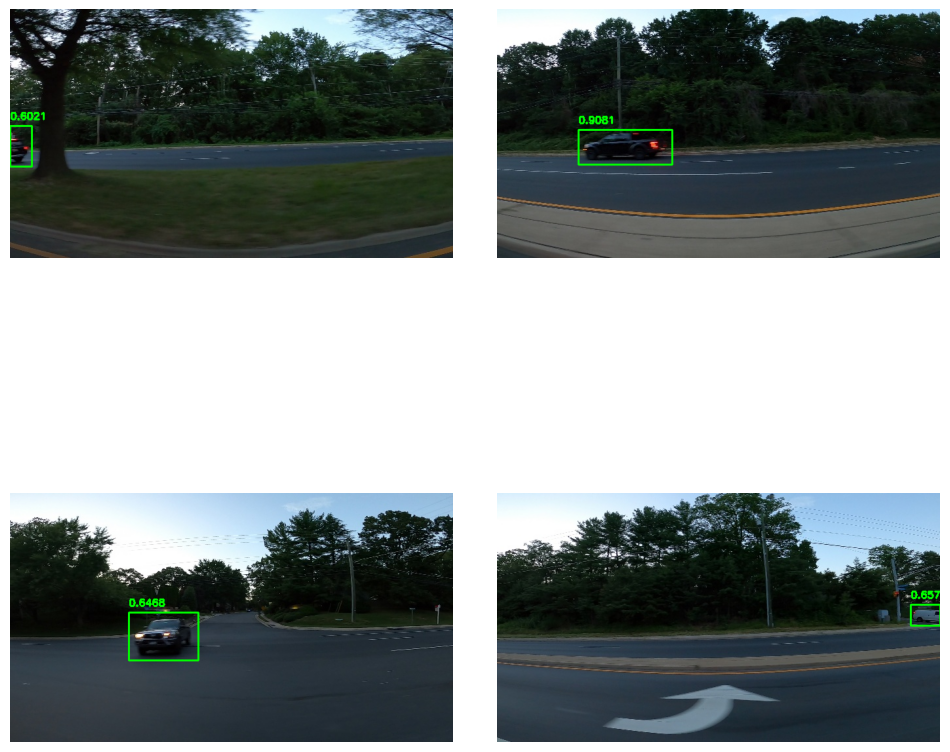

In [37]:
fig,axes=plt.subplots(2,2,figsize=(12,12))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
ax=axes.flatten()

imgs_name=np.random.choice(test_img_list,4)

for i,img_name in enumerate(imgs_name):
    img_file_path=os.path.join(test_data,img_name+".jpg")
    img=cv2.imread(img_file_path)
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    label_file_path=os.path.join(prediction_dir,img_name+".txt")
    label=pd.read_csv(label_file_path,sep=" ",header=None).values
    scores=label[:,0]
    boxes=label[:,1:]
    show_bbox(img,boxes,scores,axis=ax[i])

plt.savefig("car_detect_yolov8.png")

In [39]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [41]:
img = cv2.imread("/content/runs/detect/train/results.png")

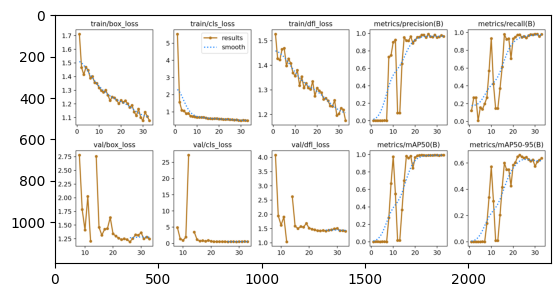

In [42]:
plt.subplot(1,1,1)
plt.imshow(img)
plt.show()

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    inter_area = max(0, x2 - x1 + 1) * max(0, y2 - y1 + 1)
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    iou = inter_area / float(box1_area + box2_area - inter_area)
    return iou

def get_metrics(true_boxes, pred_boxes, iou_threshold=0.5):
    tp, fp, fn = 0, 0, 0
    for i in range(len(true_boxes)):
        match_found = False
        for j in range(len(pred_boxes)):
            iou = compute_iou(true_boxes[i], pred_boxes[j])
            if iou >= iou_threshold:
                match_found = True
                break
        if match_found:
            tp += 1
        else:
            fn += 1
    fp = len(pred_boxes) - tp
    return tp, fp, fn

def evaluate_model(true_labels, pred_labels, iou_threshold=0.5):
    tp, fp, fn = 0, 0, 0
    for true_boxes, pred_boxes in zip(true_labels, pred_labels):
        tp_inc, fp_inc, fn_inc = get_metrics(true_boxes, pred_boxes, iou_threshold)
        tp += tp_inc
        fp += fp_inc
        fn += fn_inc
    
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    accuracy = tp / (tp + fp + fn) if tp + fp + fn > 0 else 0
    
    return tp, fp, fn, precision, recall, f1, accuracy

def compute_confusion_matrix(true_labels, pred_labels, iou_threshold=0.5):
    tp, fp, fn = 0, 0, 0
    for true_boxes, pred_boxes in zip(true_labels, pred_labels):
        tp_inc, fp_inc, fn_inc = get_metrics(true_boxes, pred_boxes, iou_threshold)
        tp += tp_inc
        fp += fp_inc
        fn += fn_inc
    tn = 0  

    return np.array([[tp, fp], [fn, tn]])

true_labels = [
    [[100, 150, 200, 250], [300, 350, 400, 450]],
    [[50, 50, 100, 100]]
]

pred_labels = [
    [[105, 155, 195, 245], [305, 355, 395, 445], [500, 500, 600, 600]],
    [[45, 45, 95, 95]]
]

conf_matrix = compute_confusion_matrix(true_labels, pred_labels)

conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual: Car', 'Actual: No Car'], columns=['Predicted: Car', 'Predicted: No Car'])

print(conf_matrix_df)

tp, fp, fn, precision, recall, f1, accuracy = evaluate_model(true_labels, pred_labels)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Accuracy: {accuracy}")


                Predicted: Car  Predicted: No Car
Actual: Car                  3                  1
Actual: No Car               0                  0
Precision: 0.75
Recall: 1.0
F1 Score: 0.8571428571428571
Accuracy: 0.75
